In [1]:
from preprocessing import *
from train_evaluate import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

# Data Setup

## Load Data

In [2]:
data_dir = '/Users/michael/Desktop/Home/研究所/ECE247/projects/data/'
X_train_valid, y_train_valid, X_test, y_test = load_data(data_dir, subjects=[1,2,3,4,5,6,7,8,9]) # default subjects=[1,2,3,4,5,6,7,8,9]

## Preprocessing

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = main_prep(X_train_valid,y_train_valid,X_test, y_test,2,2,True)

Shape of x_train: (6768, 250, 1, 22)
Shape of x_valid: (1692, 250, 1, 22)
Shape of x_test: (1772, 250, 1, 22)
Shape of y_train: torch.Size([6768, 4])
Shape of y_valid: torch.Size([1692, 4])
Shape of y_test: torch.Size([1772, 4])


## PyTorch Dataloaders

In [4]:
data_loaders  = dataloader_setup(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size=32)

## Parameters

In [5]:
LR      = 0.0005
BETAS   = (0.9, 0.999)
EPS     = 1e-08
DECAY   = 0.0005

BATCH_SIZE = 32
EPOCHS  = 100

# Modeling (CNN, LSTM, GRU, CNN+LSTM, CNN+GRU)

## Models

In [6]:
# # Building the CNN model using sequential class
class CNN(nn.Module):
    # initializers
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(800,4)
        
    # forward method
    def forward(self, input):  #input(22,250,1)
        x = input.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))
        x = self.flatten(x)
        out = self.dense(x) 
        return out
    
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

class GRU(nn.Module):
    
    def __init__(self):
        super(GRU, self).__init__()

        self.gru = nn.GRU(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1, 3)
    
class CNN_LSTM(nn.Module):
    
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        
        
        self.lstm = nn.LSTM(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):
        
        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class CNN_GRU(nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.gru = nn.GRU(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):

        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

## Initiate models

In [7]:
# initiate CNN model
cnn = CNN()
# create your cnn optimizer
cnn_optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate LSTM model
lstm = LSTM()
# create your lstm optimizer
lstm_optimizer = optim.Adam(lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate GRU model
gru = GRU()
# create your gru optimizer
gru_optimizer = optim.Adam(gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_LSTM model
cnn_lstm = CNN_LSTM()
# create your cnn_lstm optimizer
cnn_lstm_optimizer = optim.Adam(cnn_lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_GRU model
cnn_gru = CNN_GRU()
# create your cnn_gru optimizer
cnn_gru_optimizer = optim.Adam(cnn_gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

## CNN

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.46058
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.57104
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.49610
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.61831
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.57288
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.44407
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.55952
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.69810
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.41124
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.29225
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.34996
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.43967
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.46265
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.55334
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.41508
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.17823
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 0.91725
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 0.84757
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 0.83353
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.07420
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 0.97282
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.08034
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 0.82544
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 0.98334
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.13256
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.55104
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.08462
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.15319
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 0.99871
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.14440
	Train loss: 0.03202, Accuracy: 3842/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 0.83125
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 0.87285
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 0.85606
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 0.86581
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.32205
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 0.89799
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.12713
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 0.82909
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 0.95762
	Train loss: 0.02787, Accuracy: 4390/6768 (64.00%)
	Validation loss: 0.00055, Accuracy: 1095/1692 (64.00%)
	Test loss: 0.00063, Accuracy: 973/1772 (54.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.76999
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.35205
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.32626
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 0.86877
Trainin

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 0.71993
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.90007
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 0.62674
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 0.84553
	Train loss: 0.02338, Accuracy: 4800/6768 (70.00%)
	Validation loss: 0.00047, Accuracy: 1188/1692 (70.00%)
	Test loss: 0.00060, Accuracy: 1032/1772 (58.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.86521
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 0.81813
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 0.98331
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 0.97789
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 0.67420
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.70739
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 0.78738
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 0.74357
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 0.72100
Traini

	Validation loss: 0.00044, Accuracy: 1215/1692 (71.00%)
	Test loss: 0.00062, Accuracy: 1014/1772 (57.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.60063
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 0.91485
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 0.78569
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.71172
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.83234
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.36491
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.78550
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.40748
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.68612
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.46426
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.56391
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.53701
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.70932
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.74546
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.42305
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.57351
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.33445
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.91514
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.59222
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.85216
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.56071
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.52368
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.63787
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.68962
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.79615
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.68363
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.71077
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.61897
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.47676
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.51061
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.58589
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.30969
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.52628
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.65695
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.60501
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.69879
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.50006
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.41784
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.66370
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.57842
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.70504
	Train loss: 0.01606, Accuracy: 5576/6768 (82.00%)
	Validation loss: 0.00036, Accuracy: 1311/1692 (77.00%)
	Test loss: 0.00063, Accuracy: 1056/1772 (59.00%

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.48214
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.55530
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.58860
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.80711
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.42600
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.65740
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.48513
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.74094
	Train loss: 0.01337, Accuracy: 5684/6768 (83.00%)
	Validation loss: 0.00032, Accuracy: 1350/1692 (79.00%)
	Test loss: 0.00064, Accuracy: 1053/1772 (59.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.78943
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.84139
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.40784
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.42759
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.34319
Traini

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.56647
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.33646
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.51794
	Train loss: 0.01102, Accuracy: 5907/6768 (87.00%)
	Validation loss: 0.00026, Accuracy: 1408/1692 (83.00%)
	Test loss: 0.00063, Accuracy: 1054/1772 (59.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.63658
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.65690
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.50616
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.64885
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.83837
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.29780
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.52346
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.40741
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.40898
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.53961
Traini

	Test loss: 0.00060, Accuracy: 1114/1772 (62.00%)

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.60909
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.53226
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.36114
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.53911
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.37711
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.20403
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.39005
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.51539
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.38428
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.18225
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.24575
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.36905
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.43800
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.50320
Training Progress: 	Epoch 48 [4480/6768 (66.04%)

Training Progress: 	Epoch 53 [1280/6768 (18.87%)]		Loss: 0.54119
Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.24725
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.49627
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.25776
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.39604
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.32849
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.62782
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.42826
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.41446
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.27414
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.42461
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.54746
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.52094
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.38368
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.29741
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [2880/6768 (42.45%)]		Loss: 0.34861
Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.27886
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.34040
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.56688
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.65819
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.48095
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.39673
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.54401
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.43256
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.29829
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.43824
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.33499
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.35309
	Train loss: 0.00844, Accuracy: 6171/6768 (91.00%)
	Validation loss: 0.00021, Accuracy: 1481/1692 (87.00%)
	Test loss: 0.00063, Accuracy: 1091/1772 (61.00%

Training Progress: 	Epoch 63 [4480/6768 (66.04%)]		Loss: 0.28997
Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.46748
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.49482
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.46663
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.39155
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.30323
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.24510
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.49540
	Train loss: 0.00694, Accuracy: 6223/6768 (91.00%)
	Validation loss: 0.00018, Accuracy: 1498/1692 (88.00%)
	Test loss: 0.00063, Accuracy: 1083/1772 (61.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.27394
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.53561
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.38996
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.45277
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.44770
Traini

Training Progress: 	Epoch 68 [6080/6768 (89.62%)]		Loss: 0.42078
Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.19528
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.51360
	Train loss: 0.00769, Accuracy: 6175/6768 (91.00%)
	Validation loss: 0.00020, Accuracy: 1465/1692 (86.00%)
	Test loss: 0.00066, Accuracy: 1078/1772 (60.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.50604
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.64816
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.42003
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.26109
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.60085
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.53356
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.26525
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.17645
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.63022
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.25811
Traini

	Test loss: 0.00063, Accuracy: 1093/1772 (61.00%)

Training Progress: 	Epoch 74 [0/6768 (0.00%)]		Loss: 0.54422
Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.39057
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.34139
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.23082
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.42880
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.39706
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.40163
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.40135
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.46437
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.26447
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.23024
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.25417
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.33177
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.49646
Training Progress: 	Epoch 74 [4480/6768 (66.04%)

Training Progress: 	Epoch 79 [1280/6768 (18.87%)]		Loss: 0.33042
Training Progress: 	Epoch 79 [1600/6768 (23.58%)]		Loss: 0.14910
Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.33711
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.15556
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.30885
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.44914
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.35636
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.21176
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.23687
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.29874
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.23999
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.31195
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.21415
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.46132
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.40379
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [2880/6768 (42.45%)]		Loss: 0.22948
Training Progress: 	Epoch 84 [3200/6768 (47.17%)]		Loss: 0.31559
Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.62649
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.29833
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.27670
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.26052
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.31717
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.30758
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.32968
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.33310
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.34037
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.57163
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.30770
	Train loss: 0.00732, Accuracy: 6129/6768 (90.00%)
	Validation loss: 0.00019, Accuracy: 1475/1692 (87.00%)
	Test loss: 0.00069, Accuracy: 1064/1772 (60.00%

Training Progress: 	Epoch 89 [4480/6768 (66.04%)]		Loss: 0.28786
Training Progress: 	Epoch 89 [4800/6768 (70.75%)]		Loss: 0.22928
Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.24524
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.33083
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.34346
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.30325
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.18354
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.49297
	Train loss: 0.00728, Accuracy: 6183/6768 (91.00%)
	Validation loss: 0.00019, Accuracy: 1505/1692 (88.00%)
	Test loss: 0.00068, Accuracy: 1096/1772 (61.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.32034
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.60132
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.30019
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.49752
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.18101
Traini

Training Progress: 	Epoch 94 [6080/6768 (89.62%)]		Loss: 0.47532
Training Progress: 	Epoch 94 [6400/6768 (94.34%)]		Loss: 0.10538
Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.40657
	Train loss: 0.00629, Accuracy: 6267/6768 (92.00%)
	Validation loss: 0.00016, Accuracy: 1529/1692 (90.00%)
	Test loss: 0.00065, Accuracy: 1116/1772 (62.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.36557
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.22562
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.59652
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.18616
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.31027
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.25580
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.39550
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.21518
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.42360
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.24099
Traini

	Test loss: 0.00064, Accuracy: 1115/1772 (62.00%)

Training Progress: 	Epoch 100 [0/6768 (0.00%)]		Loss: 0.61626
Training Progress: 	Epoch 100 [320/6768 (4.72%)]		Loss: 0.35466
Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.28302
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.18575
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.19916
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.14456
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.16907
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.15159
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.49588
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.21044
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.36522
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.26390
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.34161
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.36592
Training Progress: 	Epoch 100 [448

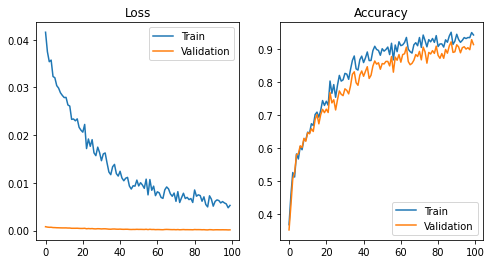

In [8]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders, num_epochs=EPOCHS)

## LSTM

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.36766
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.35595
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.46475
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.39018
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.37832
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.45167
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.36223
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.41420
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.43996
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.32874
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.41226
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.45990
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.39559
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.42868
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.42906
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.38702
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.22347
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.38781
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.30211
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.41932
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.30725
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.37513
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.35713
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.28423
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.34025
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.29774
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.28580
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.33128
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.36016
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.23617
	Train loss: 0.04106, Accuracy: 2545/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.20781
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.13126
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.02261
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.04881
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.04522
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.18079
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.13692
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.39959
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.03416
	Train loss: 0.03920, Accuracy: 2943/6768 (43.00%)
	Validation loss: 0.00077, Accuracy: 681/1692 (40.00%)
	Test loss: 0.00084, Accuracy: 546/1772 (30.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.96458
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.21620
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.11183
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.13072
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.21838
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.88568
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.20201
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 0.85694
	Train loss: 0.03646, Accuracy: 3414/6768 (50.00%)
	Validation loss: 0.00075, Accuracy: 779/1692 (46.00%)
	Test loss: 0.00094, Accuracy: 561/1772 (31.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.93307
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.07947
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 0.96990
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 0.91765
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 0.94435
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 1.01338
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.31783
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 0.87176
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 0.95026
Training

	Validation loss: 0.00074, Accuracy: 872/1692 (51.00%)
	Test loss: 0.00108, Accuracy: 568/1772 (32.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.90388
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.00677
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 1.08532
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.80185
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.90921
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.59404
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.97422
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.90883
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.80552
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 1.07044
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.71696
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.74873
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 1.23819
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0.

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 1.07341
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.58071
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.80009
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.68768
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.48561
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.89802
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.57713
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.57474
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.92610
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.84362
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.84082
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.49695
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.62441
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.93947
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.72852
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.62653
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.38091
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.66895
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.95314
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.58712
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.66480
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.46283
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.50343
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.88069
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.54017
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.51020
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.75453
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.42568
	Train loss: 0.02762, Accuracy: 4589/6768 (67.00%)
	Validation loss: 0.00070, Accuracy: 1014/1692 (59.00%)
	Test loss: 0.00136, Accuracy: 574/1772 (32.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.49129
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.38916
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.43490
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.68935
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.47855
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.29579
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.59939
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.45114
	Train loss: 0.02652, Accuracy: 4845/6768 (71.00%)
	Validation loss: 0.00069, Accuracy: 1069/1692 (63.00%)
	Test loss: 0.00140, Accuracy: 582/1772 (32.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.89732
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.46237
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.45645
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.42907
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.31806
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.30180
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.68270
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.30435
	Train loss: 0.01789, Accuracy: 5414/6768 (79.00%)
	Validation loss: 0.00052, Accuracy: 1196/1692 (70.00%)
	Test loss: 0.00145, Accuracy: 585/1772 (33.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.61258
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.42077
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.58335
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.58006
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.25699
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.23564
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.55074
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.45852
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.24617
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.32089
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.53187
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.25414
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.41532
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.36441
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.42630
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.31447
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.34362
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.33430
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.11119
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.46936
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.24612
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.29397
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.56618
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.24541
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.20276
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.21018
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.26193
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.23745
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.28922
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.35556
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.23149
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.11624
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.42560
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.23130
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.19364
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.32001
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.25661
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.50955
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.58354
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.33209
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.16329
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.28106
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.49969
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.41523
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.11009
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.14009
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.13337
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.75720
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.33226
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.11261
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.30319
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.18393
	Train loss: 0.01688, Accuracy: 5537/6768 (81.00%)
	Validation loss: 0.00055, Accuracy: 1245/1692 (73.00%)
	Test loss: 0.00182, Accuracy: 558/1772 (31.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.40257
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.15420
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.21062
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.38434
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.22469
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.12736
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.48986
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.21407
	Train loss: 0.01570, Accuracy: 5583/6768 (82.00%)
	Validation loss: 0.00052, Accuracy: 1245/1692 (73.00%)
	Test loss: 0.00186, Accuracy: 573/1772 (32.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.81950
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.20309
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.22260
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.46659
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.34659
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.26755
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.36930
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.17927
	Train loss: 0.01279, Accuracy: 5774/6768 (85.00%)
	Validation loss: 0.00045, Accuracy: 1314/1692 (77.00%)
	Test loss: 0.00183, Accuracy: 571/1772 (32.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.31602
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.19372
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.27814
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.11019
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.12721
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.21112
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.13681
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.11068
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.22389
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.28824
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.09551
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.08569
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.20585
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.07160
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.17010
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.05262
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.06711
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.11412
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.11041
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.11576
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.08075
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.13594
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.42850
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.57510
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.32780
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.12096
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.33816
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.08914
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.05518
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.18578
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.12460
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.17977
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.26461
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.10348
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.11335
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.09485
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.24564
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.60554
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.12285
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.07699
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.15206
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.23571
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.26460
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.07654
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.06433
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.10053
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.24012
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.42229
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.07568
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.22194
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.14892
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.18692
	Train loss: 0.02038, Accuracy: 5421/6768 (80.00%)
	Validation loss: 0.00063, Accuracy: 1242/1692 (73.00%)
	Test loss: 0.00219, Accuracy: 558/1772 (31.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.24715
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.16405
Trai

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.10084
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.17133
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.13793
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.17109
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.37053
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.23876
	Train loss: 0.01413, Accuracy: 5794/6768 (85.00%)
	Validation loss: 0.00050, Accuracy: 1305/1692 (77.00%)
	Test loss: 0.00212, Accuracy: 592/1772 (33.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.21229
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.15890
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.34802
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.21227
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.19285
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.24211
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.27141
Trainin

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.08854
	Train loss: 0.01396, Accuracy: 5707/6768 (84.00%)
	Validation loss: 0.00052, Accuracy: 1262/1692 (74.00%)
	Test loss: 0.00214, Accuracy: 555/1772 (31.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.33387
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.04496
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.23930
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.04557
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.11069
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.03257
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.05360
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.07350
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.16929
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.06643
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.08172
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.06152
Trainin

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.22040
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.05980
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.08897
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.02962
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.15988
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.09882
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.05009
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.27451
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.19678
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.05899
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.12777
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.09799
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.27889
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.19358
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.15415
Training Prog

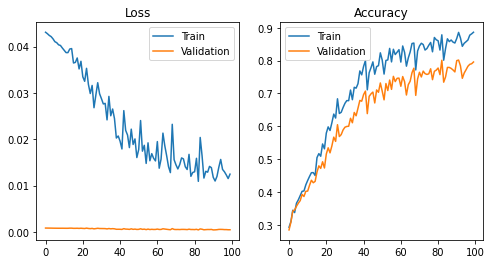

In [17]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## GRU

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.61701
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.36332
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.42349
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.47050
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.35153
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.43636
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.50179
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.34796
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.37872
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.50042
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.42771
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.46220
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.38592
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.42766
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.45746
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.30357
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.22695
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.36559
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.29208
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.37809
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.36657
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.36338
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.32481
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.30098
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.35228
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.27706
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.42663
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.40146
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.34128
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.14436
	Train loss: 0.04196, Accuracy: 2315/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.27460
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.24953
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.22284
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.15224
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.17479
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.45608
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.10564
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.27319
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 0.95179
	Train loss: 0.04083, Accuracy: 2821/6768 (41.00%)
	Validation loss: 0.00080, Accuracy: 686/1692 (40.00%)
	Test loss: 0.00086, Accuracy: 543/1772 (30.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 1.14520
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.36199
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.22491
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.20451
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.09841
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.92782
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.09265
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 0.91158
	Train loss: 0.03860, Accuracy: 3247/6768 (47.00%)
	Validation loss: 0.00079, Accuracy: 763/1692 (45.00%)
	Test loss: 0.00093, Accuracy: 588/1772 (33.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.98963
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.13631
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 1.15564
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.15446
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 1.08535
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.87435
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.05345
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 0.94566
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 0.92126
Training

	Validation loss: 0.00075, Accuracy: 835/1692 (49.00%)
	Test loss: 0.00103, Accuracy: 549/1772 (30.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.76583
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.20750
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 1.11462
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.80605
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.81190
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.52988
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 1.05602
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.98731
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.59503
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 1.20581
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.70271
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.80338
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.80062
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0.

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.83851
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.49384
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.64829
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.99598
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.63213
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.63769
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.56403
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.82808
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.63535
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.73235
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.51843
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.58460
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.71169
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.93018
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.80573
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.57453
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.43561
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.66068
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.64873
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.66504
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.54117
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.52813
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.70086
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.62547
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.51774
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.44197
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.73059
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.44593
	Train loss: 0.02802, Accuracy: 4632/6768 (68.00%)
	Validation loss: 0.00070, Accuracy: 1033/1692 (61.00%)
	Test loss: 0.00123, Accuracy: 659/1772 (37.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.23404
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.26330
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.49805
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.44846
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.38167
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.44365
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.47922
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.27569
	Train loss: 0.03011, Accuracy: 4682/6768 (69.00%)
	Validation loss: 0.00078, Accuracy: 1031/1692 (60.00%)
	Test loss: 0.00138, Accuracy: 639/1772 (36.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.46819
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.65417
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.41532
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.52571
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.43501
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.41025
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.61278
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.13002
	Train loss: 0.02951, Accuracy: 4769/6768 (70.00%)
	Validation loss: 0.00077, Accuracy: 1067/1692 (63.00%)
	Test loss: 0.00148, Accuracy: 656/1772 (37.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.49730
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.36515
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.51583
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.20608
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.35003
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.16427
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.20534
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.20710
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.24971
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.37799
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.49111
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.33719
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.44923
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.21714
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.18721
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.28798
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.30099
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.28233
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.35417
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.52675
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.20985
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.23257
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.26942
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.24132
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.26652
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.14419
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.28716
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.24268
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.14989
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.45854
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.11746
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.38390
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.10836
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.37021
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.16248
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.08541
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.23621
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.24174
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.24896
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.31438
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.10440
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.30265
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.25610
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.16828
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.19582
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.25274
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.11726
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.52153
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.41395
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.16201
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.35060
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.15403
	Train loss: 0.01755, Accuracy: 5573/6768 (82.00%)
	Validation loss: 0.00055, Accuracy: 1231/1692 (72.00%)
	Test loss: 0.00157, Accuracy: 725/1772 (40.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.59962
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.25464
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.15972
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.20260
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.18449
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.21797
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.37644
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.45870
	Train loss: 0.02949, Accuracy: 4986/6768 (73.00%)
	Validation loss: 0.00085, Accuracy: 1104/1692 (65.00%)
	Test loss: 0.00186, Accuracy: 688/1772 (38.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.49565
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.28470
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.26413
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.11708
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.26862
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.04511
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.33769
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.18267
	Train loss: 0.02267, Accuracy: 5362/6768 (79.00%)
	Validation loss: 0.00067, Accuracy: 1190/1692 (70.00%)
	Test loss: 0.00176, Accuracy: 681/1772 (38.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.44891
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.06868
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.13287
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.03928
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.25318
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.09885
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.16951
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.14742
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.18647
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.20458
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.06457
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.25428
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.36649
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.06713
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.13598
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.04189
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.18772
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.07470
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.17468
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.15037
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.14853
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.24698
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.08473
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.14528
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.10657
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.06212
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.11322
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.13698
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.17017
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.14120
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.26387
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.15409
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.10995
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.25015
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.04191
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.09340
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.26263
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.09968
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.14198
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.17475
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.17814
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.24614
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.22558
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.28303
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.15432
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.09444
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.43383
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.23886
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.10719
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.10676
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.16356
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.04025
	Train loss: 0.02082, Accuracy: 5486/6768 (81.00%)
	Validation loss: 0.00065, Accuracy: 1234/1692 (72.00%)
	Test loss: 0.00194, Accuracy: 699/1772 (39.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.38097
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.20545
Trai

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.17545
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.33594
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.06727
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.09223
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.18005
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.17874
	Train loss: 0.02943, Accuracy: 5238/6768 (77.00%)
	Validation loss: 0.00086, Accuracy: 1151/1692 (68.00%)
	Test loss: 0.00220, Accuracy: 668/1772 (37.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.20638
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.10900
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.03591
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.24564
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.11289
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.06945
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.08106
Trainin

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.08422
	Train loss: 0.02059, Accuracy: 5673/6768 (83.00%)
	Validation loss: 0.00063, Accuracy: 1292/1692 (76.00%)
	Test loss: 0.00194, Accuracy: 720/1772 (40.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.40080
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.16652
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.26865
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.21446
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.02222
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.05673
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.10948
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.06328
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.12273
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.02470
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.06199
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.09973
Trainin

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.07209
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.16742
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.05213
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.02984
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.15736
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.19429
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.02379
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.13899
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.11065
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.09170
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.30002
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.07556
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.09697
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.13692
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.07852
Training Prog

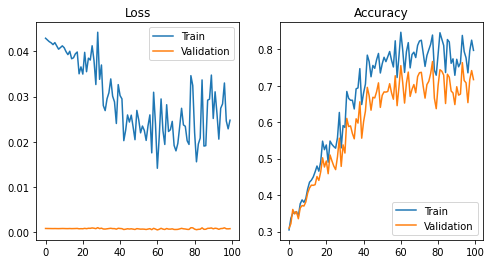

In [20]:
train_and_evaluate(gru, gru_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+LSTM

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.49864
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.40551
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.44457
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.40890
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.39938
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.37963
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.47968
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.40555
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.41232
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.36486
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.36251
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.41141
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.36253
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.33095
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.36439
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.12449
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.27307
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.14980
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.00185
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.31892
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.18385
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.36910
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.15572
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.18151
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.14790
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.18423
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.11119
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.18973
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.13559
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.24057
	Train loss: 0.03720, Accuracy: 3044/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.15413
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.13358
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 0.98148
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.00653
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.12844
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.00253
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.05326
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.22223
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.13012
	Train loss: 0.03667, Accuracy: 3224/6768 (47.00%)
	Validation loss: 0.00072, Accuracy: 778/1692 (45.00%)
	Test loss: 0.00072, Accuracy: 754/1772 (42.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.95151
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.08932
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.11606
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.04754
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.04019
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 1.04064
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.01300
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.19921
	Train loss: 0.03440, Accuracy: 3434/6768 (50.00%)
	Validation loss: 0.00068, Accuracy: 814/1692 (48.00%)
	Test loss: 0.00071, Accuracy: 755/1772 (42.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.97556
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.16594
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 1.19479
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.05348
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 1.11111
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.94333
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.26465
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 1.01941
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 0.92753
Training

	Validation loss: 0.00067, Accuracy: 848/1692 (50.00%)
	Test loss: 0.00073, Accuracy: 739/1772 (41.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.90474
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.12256
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 1.11362
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.77910
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.90196
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.77739
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 1.17875
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.81110
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.94125
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.86188
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.81695
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.97868
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.99204
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0.

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 1.02849
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.85603
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 1.09110
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.69125
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 1.09768
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.95935
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.86164
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.81447
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.80690
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.76298
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.95031
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 1.05481
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.82064
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.96609
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.96014
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 1.00360
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.72072
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.96471
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.87484
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 1.07141
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.99738
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.94800
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.86335
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.90340
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.69541
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.95848
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.60712
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.82327
	Train loss: 0.02865, Accuracy: 4006/6768 (59.00%)
	Validation loss: 0.00061, Accuracy: 905/1692 (53.00%)
	Test loss: 0.00074, Accuracy: 781/1772 (44.00%)


Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.96062
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.87095
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.80149
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.81921
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.75736
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.94520
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.67533
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 1.02517
	Train loss: 0.02443, Accuracy: 4526/6768 (66.00%)
	Validation loss: 0.00052, Accuracy: 1038/1692 (61.00%)
	Test loss: 0.00068, Accuracy: 845/1772 (47.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.87711
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.71371
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.89904
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.68173
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.89597
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.85037
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.70030
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.94166
	Train loss: 0.02373, Accuracy: 4494/6768 (66.00%)
	Validation loss: 0.00053, Accuracy: 1025/1692 (60.00%)
	Test loss: 0.00070, Accuracy: 818/1772 (46.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.66637
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.98332
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 1.05562
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.79360
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.80682
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.74846
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 1.02581
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.75416
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.73441
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.60565
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.72708
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 1.09959
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.91748
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.88851
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.87204
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.48751
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 1.08203
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.58289
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.87619
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.81430
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.72869
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.61343
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.65206
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.75410
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.84271
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.53693
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.81706
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.68776
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.51781
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.71006
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.65500
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.65201
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.50005
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.78009
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.67137
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.91219
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.61037
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.73302
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.62061
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.78525
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.64230
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.76311
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.69928
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.95781
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.94417
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.71256
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.65008
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.95099
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.61008
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.80122
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.59324
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.67743
	Train loss: 0.01814, Accuracy: 5139/6768 (75.00%)
	Validation loss: 0.00042, Accuracy: 1168/1692 (69.00%)
	Test loss: 0.00070, Accuracy: 882/1772 (49.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.91697
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.72195
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.77637
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.81190
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.50451
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.69141
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.57460
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.73740
	Train loss: 0.01954, Accuracy: 4970/6768 (73.00%)
	Validation loss: 0.00045, Accuracy: 1150/1692 (67.00%)
	Test loss: 0.00071, Accuracy: 885/1772 (49.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.72499
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.72398
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.80241
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.59234
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.84794
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.66138
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.65277
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.81286
	Train loss: 0.01862, Accuracy: 5046/6768 (74.00%)
	Validation loss: 0.00044, Accuracy: 1150/1692 (67.00%)
	Test loss: 0.00073, Accuracy: 860/1772 (48.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.78173
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.89391
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.86553
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.52450
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.50372
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.63870
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.79091
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.77585
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.86239
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.55092
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.53768
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.81349
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.68421
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.51605
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.77499
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.55417
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.81777
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.52179
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.54596
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.63065
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.49528
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.75639
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.50142
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.67036
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.73264
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.66939
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.83059
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.81096
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.69472
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.45217
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.43249
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.58109
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.76206
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.66286
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.65942
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.80635
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.72137
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.52184
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.56557
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.68007
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.52803
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.62521
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.52715
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.59514
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.63036
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.63974
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.74842
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.57475
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.55781
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.65771
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.45178
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.82667
	Train loss: 0.01719, Accuracy: 5135/6768 (75.00%)
	Validation loss: 0.00041, Accuracy: 1194/1692 (70.00%)
	Test loss: 0.00080, Accuracy: 866/1772 (48.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.64547
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.56102
Trai

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.59791
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.71018
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.43872
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.55844
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.44314
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.65524
	Train loss: 0.01346, Accuracy: 5631/6768 (83.00%)
	Validation loss: 0.00033, Accuracy: 1297/1692 (76.00%)
	Test loss: 0.00074, Accuracy: 908/1772 (51.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.78812
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.75624
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.75501
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.64999
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.39068
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.66628
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.88592
Trainin

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.55980
	Train loss: 0.01831, Accuracy: 5091/6768 (75.00%)
	Validation loss: 0.00045, Accuracy: 1153/1692 (68.00%)
	Test loss: 0.00081, Accuracy: 893/1772 (50.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.69143
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.67982
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.87276
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.52484
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.61191
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.36141
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.84887
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.46436
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.66293
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.62413
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.42230
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.71498
Trainin

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.71970
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.43859
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.54962
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.39492
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.65530
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.40770
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.78219
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.76529
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.51370
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.69761
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.52208
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.49714
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.45634
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.57951
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.52331
Training Prog

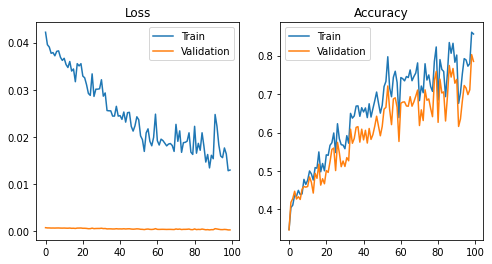

In [55]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+GRU

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.30810
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.38942
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.40191
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.42637
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.45949
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.42487
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.34933
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.38494
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.34921
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.27871
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.37201
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.36708
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.46088
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.42834
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.41323
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.06708
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.19705
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.14270
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 0.99974
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.13341
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.02061
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.18812
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.16971
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.26012
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.11025
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.24283
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.04785
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.16840
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.16466
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.19039
	Train loss: 0.03838, Accuracy: 2819/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.20169
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.08081
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.07630
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 0.92159
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.04989
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.19983
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.12436
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 0.92720
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.19327
	Train loss: 0.03781, Accuracy: 2957/6768 (43.00%)
	Validation loss: 0.00075, Accuracy: 671/1692 (39.00%)
	Test loss: 0.00071, Accuracy: 660/1772 (37.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.86421
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.40741
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.17484
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 0.91721
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.02016
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.96722
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 0.87513
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.00073
	Train loss: 0.03373, Accuracy: 3431/6768 (50.00%)
	Validation loss: 0.00068, Accuracy: 817/1692 (48.00%)
	Test loss: 0.00069, Accuracy: 731/1772 (41.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.87886
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 0.97886
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 1.20843
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 0.87754
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 1.06944
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.87504
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.46406
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 0.83778
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 1.29386
Training

	Validation loss: 0.00074, Accuracy: 743/1692 (43.00%)
	Test loss: 0.00074, Accuracy: 708/1772 (39.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 1.00682
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.31546
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 1.06369
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.92438
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.73833
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.83275
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 1.22065
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.81826
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 1.07760
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.88927
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.83277
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.77676
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.93023
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0.

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.91063
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.69302
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 1.08521
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.79473
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 1.08662
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.78199
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.80261
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.76133
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.72044
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.84748
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.75628
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.85760
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.82155
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.75133
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.78322
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.78132
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.60769
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.89328
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.60096
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.85151
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.86374
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.86883
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.68666
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 1.00174
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.65950
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.71175
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.78531
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.89870
	Train loss: 0.02870, Accuracy: 3927/6768 (58.00%)
	Validation loss: 0.00062, Accuracy: 880/1692 (52.00%)
	Test loss: 0.00069, Accuracy: 746/1772 (42.00%)


Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.75056
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.95050
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.59209
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.90919
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.69850
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.88679
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.76459
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 1.03851
	Train loss: 0.02730, Accuracy: 4201/6768 (62.00%)
	Validation loss: 0.00060, Accuracy: 953/1692 (56.00%)
	Test loss: 0.00070, Accuracy: 799/1772 (45.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.91737
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.97616
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.75884
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.62812
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.59846
Training

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.87517
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.71029
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.74293
	Train loss: 0.02266, Accuracy: 4642/6768 (68.00%)
	Validation loss: 0.00051, Accuracy: 1058/1692 (62.00%)
	Test loss: 0.00069, Accuracy: 842/1772 (47.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.69240
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.86613
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.77048
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.60521
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.76179
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.62793
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.78238
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.77521
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.81904
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.66716
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.71878
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.74401
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.77567
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.66791
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.56582
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.76255
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.94671
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.65989
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.70627
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.74037
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.77618
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.50600
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.60490
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.61270
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.63021
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.59280
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.88598
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.61372
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.55363
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.55408
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.52993
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.64243
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.73216
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.61730
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.90785
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.73269
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.63133
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.85273
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.50455
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.75212
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.46045
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.59266
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.50689
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.59069
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.71238
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.90775
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.51489
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.59727
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.96812
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.69066
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.91883
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.61676
	Train loss: 0.01941, Accuracy: 5078/6768 (75.00%)
	Validation loss: 0.00048, Accuracy: 1152/1692 (68.00%)
	Test loss: 0.00072, Accuracy: 870/1772 (49.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.64751
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.51811
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.50821
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.72420
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.65150
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.68170
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.42768
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.44208
	Train loss: 0.01632, Accuracy: 5548/6768 (81.00%)
	Validation loss: 0.00041, Accuracy: 1268/1692 (74.00%)
	Test loss: 0.00067, Accuracy: 969/1772 (54.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.77202
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.78333
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.64081
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.60276
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.62891
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.35494
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.49883
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.39411
	Train loss: 0.01302, Accuracy: 5791/6768 (85.00%)
	Validation loss: 0.00035, Accuracy: 1313/1692 (77.00%)
	Test loss: 0.00064, Accuracy: 970/1772 (54.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.72756
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.67079
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.60645
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.44854
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.46386
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.64191
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.79349
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.53050
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.48346
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.49185
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.35699
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.56459
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.77443
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.43454
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.52888
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.36110
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.74841
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.43800
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 1.02172
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.57211
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.40662
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.57630
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.43714
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.34675
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.73988
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.57523
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.84799
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.40171
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.61391
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.37206
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.26794
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.52663
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.32604
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.65026
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.49883
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.49532
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.50966
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.63123
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.40266
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.41799
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.49180
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.51173
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.39483
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.43453
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.55527
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.61491
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.44686
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.64334
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.58459
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.55845
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.54568
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.49555
	Train loss: 0.00872, Accuracy: 6237/6768 (92.00%)
	Validation loss: 0.00025, Accuracy: 1463/1692 (86.00%)
	Test loss: 0.00060, Accuracy: 1060/1772 (59.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.33173
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.43461
Tra

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.41999
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.49625
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.40895
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.71667
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.52125
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.48973
	Train loss: 0.00774, Accuracy: 6303/6768 (93.00%)
	Validation loss: 0.00023, Accuracy: 1492/1692 (88.00%)
	Test loss: 0.00060, Accuracy: 1071/1772 (60.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.46432
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.77792
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.71418
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.24278
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.28242
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.44766
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.59836
Traini

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.25263
	Train loss: 0.00867, Accuracy: 6200/6768 (91.00%)
	Validation loss: 0.00026, Accuracy: 1443/1692 (85.00%)
	Test loss: 0.00067, Accuracy: 1004/1772 (56.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.67518
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.63536
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.76043
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.57765
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.26728
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.25569
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.63481
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.41124
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.30443
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.38823
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.37421
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.72723
Traini

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.60527
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.37460
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.19153
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.43208
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.51617
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.45983
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.43626
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.30464
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.29892
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.43778
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.43090
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.30579
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.17748
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.66340
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.33469
Training Prog

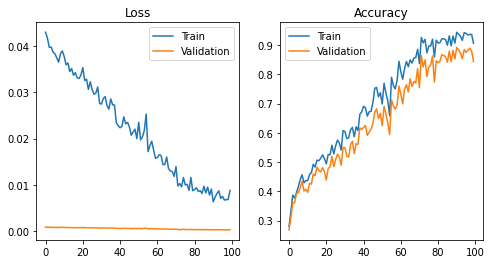

In [56]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders, num_epochs=EPOCHS)

# GAN Data Augmentation

In [8]:
fake_WGAN = np.load('./GAN/WGAN_generate_X.npy')
fake_label = np.load('./GAN/generate_label.npy')

fake_WGAN = np.swapaxes(fake_WGAN, 1,2)
fake_WGAN = np.swapaxes(fake_WGAN,2,3)

#Add 8460/4 fake data
x_train_plus_WGAN = np.vstack((x_train, fake_WGAN[0:fake_WGAN.shape[0]//4]))
y_train_plus_WGAN = np.vstack((y_train, fake_label[0:fake_WGAN.shape[0]//4]))
p = np.random.permutation(x_train.shape[0])
x_train_plus_WGAN, y_train_plus_WGAN = x_train_plus_WGAN[p], y_train_plus_WGAN[p]

In [9]:
data_loaders_wgan = dataloader_setup(x_train_plus_WGAN, y_train_plus_WGAN, x_valid, y_valid, x_test, y_test, batch_size=32)

In [10]:
fake_ACGAN = np.load('./GAN/ACGAN_generate_X.npy')
fake_label = np.load('./GAN/generate_label.npy')

fake_ACGAN = np.swapaxes(fake_ACGAN, 1,2)
fake_ACGAN = np.swapaxes(fake_ACGAN,2,3)


#Add 8460/4 fake data
x_train_plus_ACGAN = np.vstack((x_train, fake_WGAN[0:fake_ACGAN.shape[0]//4]))
y_train_plus_ACGAN = np.vstack((y_train, fake_label[0:fake_ACGAN.shape[0]//4]))
p = np.random.permutation(x_train.shape[0])
x_train_plus_ACGAN, y_train_plus_ACGAN = x_train_plus_ACGAN[p], y_train_plus_ACGAN[p]

In [11]:
data_loaders_acgan = dataloader_setup(x_train_plus_ACGAN, y_train_plus_ACGAN, x_valid, y_valid, x_test, y_test, batch_size=32)

# ACGAN

## CNN

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.67252
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.63236
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.41847
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.36450
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.55478
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.44000
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.61453
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.48255
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.35901
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.40006
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.45883
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.57594
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.39963
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.34614
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.42274
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.19579
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.17866
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.33782
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 0.99225
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 0.98126
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 0.95149
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.05098
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 0.94507
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.17356
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 0.97712
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.21734
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.11138
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.13649
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.11503
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.00362
	Train loss: 0.02807, Accuracy: 4536/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 0.96951
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.01929
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 0.95956
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.01296
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 0.96476
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 0.92568
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 0.80413
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.09492
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.10338
	Train loss: 0.02041, Accuracy: 5304/6768 (78.00%)
	Validation loss: 0.00042, Accuracy: 1229/1692 (72.00%)
	Test loss: 0.00052, Accuracy: 1154/1772 (65.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.92238
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.03421
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 0.78679
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 0.89613
Traini

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 0.88164
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.62776
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.07496
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 0.71344
	Train loss: 0.01530, Accuracy: 5686/6768 (84.00%)
	Validation loss: 0.00035, Accuracy: 1305/1692 (77.00%)
	Test loss: 0.00053, Accuracy: 1147/1772 (64.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.86102
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.01583
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 0.83190
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 0.94665
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 0.71410
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.89153
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 0.89715
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 1.06498
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 0.82325
Traini

	Validation loss: 0.00027, Accuracy: 1457/1692 (86.00%)
	Test loss: 0.00050, Accuracy: 1206/1772 (68.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.57689
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 0.92753
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 0.75921
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.65511
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.93168
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.73935
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.74002
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.99493
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.74570
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.62005
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.70924
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.63223
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.70448
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.66996
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.53269
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.48914
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 1.02919
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.46856
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.79253
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.60451
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.47738
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.61358
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.51969
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.62604
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.51831
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.41185
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.68107
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.62474
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.45447
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.61851
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.75184
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.46654
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.32597
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.64145
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.63923
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.59658
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.46346
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.79484
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.33075
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.58253
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.72950
	Train loss: 0.00566, Accuracy: 6514/6768 (96.00%)
	Validation loss: 0.00017, Accuracy: 1549/1692 (91.00%)
	Test loss: 0.00055, Accuracy: 1154/1772 (65.00%

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.65402
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.39872
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.49961
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.47481
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.56149
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.64131
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.50371
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.78949
	Train loss: 0.00407, Accuracy: 6646/6768 (98.00%)
	Validation loss: 0.00014, Accuracy: 1592/1692 (94.00%)
	Test loss: 0.00053, Accuracy: 1196/1772 (67.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.46648
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.45358
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.57844
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.71242
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.67886
Traini

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.49240
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.55276
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.39459
	Train loss: 0.00344, Accuracy: 6682/6768 (98.00%)
	Validation loss: 0.00012, Accuracy: 1609/1692 (95.00%)
	Test loss: 0.00055, Accuracy: 1209/1772 (68.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.32967
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.49416
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.31253
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.40739
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.69183
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.45798
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.55455
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.54045
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.43394
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.55266
Traini

	Test loss: 0.00056, Accuracy: 1221/1772 (68.00%)

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.23216
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.22729
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.36004
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.48304
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.42773
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.37026
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.67010
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.55223
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.61737
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.47009
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 1.03567
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.72387
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.58446
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.50913
Training Progress: 	Epoch 48 [4480/6768 (66.04%)

Training Progress: 	Epoch 53 [1280/6768 (18.87%)]		Loss: 0.45157
Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.42141
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.46560
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.56967
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.69147
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.40441
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.60360
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.24638
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.54320
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.58463
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.32010
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.31064
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.56808
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.56951
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.63337
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [2880/6768 (42.45%)]		Loss: 0.30697
Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.37639
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.35330
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.64957
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.31171
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.59590
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.27812
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.48025
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.28810
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.32559
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.53639
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.36305
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.35677
	Train loss: 0.00181, Accuracy: 6743/6768 (99.00%)
	Validation loss: 0.00007, Accuracy: 1645/1692 (97.00%)
	Test loss: 0.00060, Accuracy: 1206/1772 (68.00%

Training Progress: 	Epoch 63 [4480/6768 (66.04%)]		Loss: 0.38146
Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.28081
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.27235
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.34203
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.27841
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.30994
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.68797
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.49870
	Train loss: 0.00155, Accuracy: 6744/6768 (99.00%)
	Validation loss: 0.00006, Accuracy: 1658/1692 (97.00%)
	Test loss: 0.00058, Accuracy: 1216/1772 (68.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.41407
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.53752
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.27176
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.81611
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.41234
Traini

Training Progress: 	Epoch 68 [6080/6768 (89.62%)]		Loss: 0.52032
Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.57053
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.54855
	Train loss: 0.00124, Accuracy: 6750/6768 (99.00%)
	Validation loss: 0.00006, Accuracy: 1661/1692 (98.00%)
	Test loss: 0.00057, Accuracy: 1187/1772 (66.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.33019
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.38828
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.25743
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.20944
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.31759
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.53579
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.38069
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.42281
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.48958
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.37553
Traini

	Test loss: 0.00061, Accuracy: 1160/1772 (65.00%)

Training Progress: 	Epoch 74 [0/6768 (0.00%)]		Loss: 0.33791
Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.33916
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.47814
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.41228
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.47363
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.24358
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.64390
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.24201
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.19074
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.48156
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.44937
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.35121
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.43613
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.41174
Training Progress: 	Epoch 74 [4480/6768 (66.04%)

Training Progress: 	Epoch 79 [1280/6768 (18.87%)]		Loss: 0.36106
Training Progress: 	Epoch 79 [1600/6768 (23.58%)]		Loss: 0.52662
Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.20271
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.33864
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.24469
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.21577
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.41554
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.26859
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.44656
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.26167
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.22940
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.22834
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.46695
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.41683
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.35956
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [2880/6768 (42.45%)]		Loss: 0.24757
Training Progress: 	Epoch 84 [3200/6768 (47.17%)]		Loss: 0.45979
Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.41049
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.49093
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.38188
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.36680
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.40977
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.36253
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.38548
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.54154
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.18666
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.54761
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.38758
	Train loss: 0.00081, Accuracy: 6757/6768 (99.00%)
	Validation loss: 0.00004, Accuracy: 1669/1692 (98.00%)
	Test loss: 0.00060, Accuracy: 1193/1772 (67.00%

Training Progress: 	Epoch 89 [4480/6768 (66.04%)]		Loss: 0.31085
Training Progress: 	Epoch 89 [4800/6768 (70.75%)]		Loss: 0.44244
Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.38167
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.29348
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.34943
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.28749
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.30269
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.27833
	Train loss: 0.00076, Accuracy: 6763/6768 (99.00%)
	Validation loss: 0.00004, Accuracy: 1674/1692 (98.00%)
	Test loss: 0.00062, Accuracy: 1169/1772 (65.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.36565
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.29924
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.19242
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.34739
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.29663
Traini

Training Progress: 	Epoch 94 [6080/6768 (89.62%)]		Loss: 0.26145
Training Progress: 	Epoch 94 [6400/6768 (94.34%)]		Loss: 0.32195
Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.21380
	Train loss: 0.00071, Accuracy: 6763/6768 (99.00%)
	Validation loss: 0.00004, Accuracy: 1677/1692 (99.00%)
	Test loss: 0.00062, Accuracy: 1179/1772 (66.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.25541
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.34533
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.29423
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.47995
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.18933
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.14345
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.21113
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.35933
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.23397
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.37832
Traini

	Test loss: 0.00062, Accuracy: 1196/1772 (67.00%)

Training Progress: 	Epoch 100 [0/6768 (0.00%)]		Loss: 0.28581
Training Progress: 	Epoch 100 [320/6768 (4.72%)]		Loss: 0.51233
Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.36353
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.47584
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.21980
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.18243
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.50416
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.33813
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.26461
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.31495
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.36840
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.10327
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.53572
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.20257
Training Progress: 	Epoch 100 [448

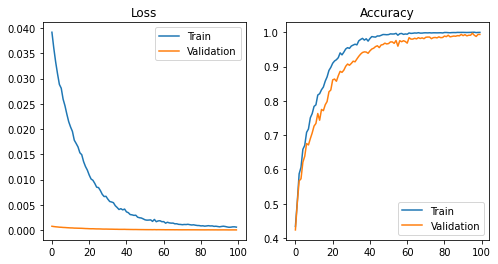

In [52]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## LSTM

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.46685
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.41770
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.42353
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.46140
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.43312
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.48316
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.41534
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.40484
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.42347
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.34464
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.41453
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.36902
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.40778
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.44674
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.42980
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.29398
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.31143
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.28089
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.32428
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.35203
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.23310
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.34560
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.26537
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.24333
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.43557
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.32991
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.30943
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.29492
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.24718
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.25722
	Train loss: 0.03998, Accuracy: 2831/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.20822
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.13422
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.15082
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.24351
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.13611
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.18309
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.07318
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 0.98831
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.22036
	Train loss: 0.03462, Accuracy: 3574/6768 (52.00%)
	Validation loss: 0.00072, Accuracy: 749/1692 (44.00%)
	Test loss: 0.00082, Accuracy: 536/1772 (30.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 1.28735
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.23424
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.32686
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.30783
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.03359
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.95279
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 0.82528
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.02223
	Train loss: 0.02913, Accuracy: 4291/6768 (63.00%)
	Validation loss: 0.00067, Accuracy: 877/1692 (51.00%)
	Test loss: 0.00090, Accuracy: 490/1772 (27.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 1.07165
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.26566
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 1.10425
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.15306
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 1.05032
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 1.12056
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.00483
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 0.96868
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 1.20941
Training

	Validation loss: 0.00060, Accuracy: 967/1692 (57.00%)
	Test loss: 0.00098, Accuracy: 531/1772 (29.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.95282
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 0.88022
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 1.07534
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 1.01219
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 1.04362
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.93421
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.80372
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 1.04289
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 1.09971
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.71398
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.94917
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 1.02565
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.81801
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0.

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.67591
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.89770
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.66228
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.89977
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 1.01130
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.83673
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.65089
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.86164
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.65495
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.57070
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.85887
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.65601
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.69457
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.78657
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.72674
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.43067
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.62193
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.48562
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.71514
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.51970
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.84467
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.57926
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.70908
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.70319
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.49240
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.82006
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.71087
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.53974
	Train loss: 0.01551, Accuracy: 5579/6768 (82.00%)
	Validation loss: 0.00045, Accuracy: 1155/1692 (68.00%)
	Test loss: 0.00113, Accuracy: 554/1772 (31.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.53080
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.40865
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.47374
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.57509
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.64411
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.73199
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.40531
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.40116
	Train loss: 0.01315, Accuracy: 5758/6768 (85.00%)
	Validation loss: 0.00042, Accuracy: 1234/1692 (72.00%)
	Test loss: 0.00128, Accuracy: 547/1772 (30.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.63314
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.91704
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.73685
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.53284
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.60596
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.61229
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.47000
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.45237
	Train loss: 0.00930, Accuracy: 6085/6768 (89.00%)
	Validation loss: 0.00034, Accuracy: 1330/1692 (78.00%)
	Test loss: 0.00132, Accuracy: 554/1772 (31.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.60670
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.66740
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.70261
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.56409
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.61971
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.61856
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.40088
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.65670
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.54381
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.52973
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.60893
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.63021
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.42958
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.47107
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.40629
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.52535
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.41942
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.48824
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.46746
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.41318
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.46267
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.25732
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.59129
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.30781
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.39128
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.40945
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.35129
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.47226
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.29286
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.34910
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.31280
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.56521
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.45571
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.19468
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.34897
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.34446
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.18683
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.45970
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.34575
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.53980
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.23564
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.34603
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.37159
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.16845
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.32817
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.31515
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.11689
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.40837
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.25662
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.15017
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.24801
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.17099
	Train loss: 0.00471, Accuracy: 6451/6768 (95.00%)
	Validation loss: 0.00024, Accuracy: 1445/1692 (85.00%)
	Test loss: 0.00155, Accuracy: 562/1772 (31.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.56200
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.13122
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.25063
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.24280
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.39430
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.23008
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.14360
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.32720
	Train loss: 0.00612, Accuracy: 6307/6768 (93.00%)
	Validation loss: 0.00029, Accuracy: 1411/1692 (83.00%)
	Test loss: 0.00163, Accuracy: 546/1772 (30.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.56919
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.55795
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.15577
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.26384
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.38876
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.45546
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.09087
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.12494
	Train loss: 0.00371, Accuracy: 6516/6768 (96.00%)
	Validation loss: 0.00020, Accuracy: 1494/1692 (88.00%)
	Test loss: 0.00168, Accuracy: 524/1772 (29.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.26110
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.60624
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.23801
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.35324
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.18831
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.22460
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.07835
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.09426
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.27052
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.06055
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.31008
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.36007
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.30657
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.20086
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.40090
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.31515
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.30105
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.20171
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.08153
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.26309
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.31040
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.15894
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.28112
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.15503
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.23208
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.12676
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.05290
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.19770
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.26080
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.21049
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.33280
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.33703
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.29822
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.15364
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.53063
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.36861
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.05566
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.26915
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.21459
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.23185
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.19918
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.15146
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.42249
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.20456
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.37297
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.11962
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.05584
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.16462
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.04350
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.09881
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.37126
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.13534
	Train loss: 0.00294, Accuracy: 6556/6768 (96.00%)
	Validation loss: 0.00017, Accuracy: 1530/1692 (90.00%)
	Test loss: 0.00169, Accuracy: 573/1772 (32.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.21795
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.31451
Trai

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.06824
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.15549
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.03017
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.04515
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.14689
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.20882
	Train loss: 0.00294, Accuracy: 6541/6768 (96.00%)
	Validation loss: 0.00017, Accuracy: 1513/1692 (89.00%)
	Test loss: 0.00172, Accuracy: 584/1772 (32.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.26114
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.11917
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.08164
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.26579
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.30710
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.13278
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.07766
Trainin

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.07552
	Train loss: 0.00226, Accuracy: 6612/6768 (97.00%)
	Validation loss: 0.00017, Accuracy: 1533/1692 (90.00%)
	Test loss: 0.00190, Accuracy: 532/1772 (30.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.18310
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.08389
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.12844
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.13373
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.26589
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.16045
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.04036
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.41600
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.42017
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.26977
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.21828
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.12039
Trainin

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.18341
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.35533
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.20499
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.23727
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.02486
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.21573
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.17478
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.17134
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.19355
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.24910
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.37153
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.19125
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.04127
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.06553
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.03888
Training Prog

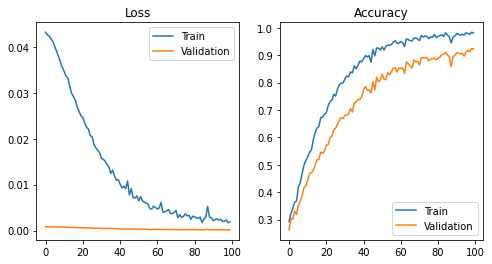

In [48]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## GRU

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.55227
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.43199
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.49540
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.55626
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.34794
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.35239
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.35925
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.41089
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.47074
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.29287
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.39019
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.36379
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.33574
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.37152
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.45336
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.34824
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.34704
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.36948
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.29944
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.46816
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.26641
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.36709
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.38401
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.27302
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.35661
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.31250
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.29963
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.25626
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.29964
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.35669
	Train loss: 0.03985, Accuracy: 2754/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.08210
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.23180
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.17843
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.15770
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.12540
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.25411
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.09805
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.09986
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.15964
	Train loss: 0.03507, Accuracy: 3495/6768 (51.00%)
	Validation loss: 0.00073, Accuracy: 725/1692 (42.00%)
	Test loss: 0.00084, Accuracy: 561/1772 (31.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 1.26133
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.08268
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.15780
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.24194
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.16898
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 1.07664
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 0.81781
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.07072
	Train loss: 0.02838, Accuracy: 4322/6768 (63.00%)
	Validation loss: 0.00063, Accuracy: 940/1692 (55.00%)
	Test loss: 0.00081, Accuracy: 664/1772 (37.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 1.04098
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.09676
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 0.84089
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.05601
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 0.84426
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 1.04452
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 0.95576
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 1.05536
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 1.05750
Training

	Validation loss: 0.00048, Accuracy: 1146/1692 (67.00%)
	Test loss: 0.00082, Accuracy: 781/1772 (44.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.73910
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 0.78194
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 0.69621
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.66705
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 0.68525
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.71359
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.82577
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 0.82052
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.80665
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.64846
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.63292
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 0.97816
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 0.70893
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 0.50050
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.50370
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.50650
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.69379
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.51343
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 0.49265
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.49504
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.97394
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.65533
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.50756
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.45327
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.36423
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.53941
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.45812
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.66660
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.50448
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.32353
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.76983
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.40379
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.46562
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.48761
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.21916
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.35928
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.39549
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.68562
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.52218
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.43020
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.54723
	Train loss: 0.01181, Accuracy: 5858/6768 (86.00%)
	Validation loss: 0.00034, Accuracy: 1353/1692 (79.00%)
	Test loss: 0.00098, Accuracy: 760/1772 (42.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.36710
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.29631
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.52781
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.34452
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.34075
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.41936
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.25030
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.44508
	Train loss: 0.00896, Accuracy: 6075/6768 (89.00%)
	Validation loss: 0.00029, Accuracy: 1407/1692 (83.00%)
	Test loss: 0.00108, Accuracy: 745/1772 (42.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.29876
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.32609
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.25842
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.38375
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.26789
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.47431
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.37517
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.32783
	Train loss: 0.00689, Accuracy: 6242/6768 (92.00%)
	Validation loss: 0.00026, Accuracy: 1449/1692 (85.00%)
	Test loss: 0.00117, Accuracy: 772/1772 (43.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.59143
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.36633
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.29393
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.66900
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.27605
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.32364
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.26714
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.42200
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.38280
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.31853
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.23067
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.36130
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.35726
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.49047
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.23124
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.19466
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.38037
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.36495
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.17808
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.39773
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.26689
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.31912
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.23373
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.14624
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.13275
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.14110
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.22529
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.27526
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.21143
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.12290
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.15405
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.44728
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.31338
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.22885
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.06396
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.12551
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.22898
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.32275
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.27607
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.37590
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.19233
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.10696
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.39011
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.26421
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.08545
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.26099
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.31897
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.26337
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.30996
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.38454
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.27508
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.09371
	Train loss: 0.00321, Accuracy: 6528/6768 (96.00%)
	Validation loss: 0.00017, Accuracy: 1521/1692 (89.00%)
	Test loss: 0.00136, Accuracy: 809/1772 (45.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.20197
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.10585
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.11255
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.24969
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.13815
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.28013
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.08212
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.14928
	Train loss: 0.00237, Accuracy: 6625/6768 (97.00%)
	Validation loss: 0.00015, Accuracy: 1545/1692 (91.00%)
	Test loss: 0.00139, Accuracy: 826/1772 (46.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.15387
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.25384
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.28115
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.23083
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.27435
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.07412
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.26092
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.05464
	Train loss: 0.00400, Accuracy: 6450/6768 (95.00%)
	Validation loss: 0.00018, Accuracy: 1514/1692 (89.00%)
	Test loss: 0.00151, Accuracy: 788/1772 (44.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.07566
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.12164
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.06908
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.20895
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.08815
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.09087
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.20358
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.38749
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.04144
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.20328
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.22404
Trainin

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.11906
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.14493
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.26018
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.12758
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.13792
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.20366
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.31283
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.15033
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.08287
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.27300
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.31101
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.37099
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.21110
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.30378
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.18902
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.12108
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.02729
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.15623
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.02515
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.06843
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.06113
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.11253
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.06541
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.02556
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.09496
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.30066
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.09644
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.18259
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.14072
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.16277
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.36249
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.10498
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.06970
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.06289
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.09705
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.10755
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.09131
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.09929
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.22329
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.25445
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.02901
	Train loss: 0.00159, Accuracy: 6659/6768 (98.00%)
	Validation loss: 0.00011, Accuracy: 1590/1692 (93.00%)
	Test loss: 0.00154, Accuracy: 823/1772 (46.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.08254
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.07600
Trai

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.07270
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.03905
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.08250
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.25235
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.08941
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.05635
	Train loss: 0.00155, Accuracy: 6672/6768 (98.00%)
	Validation loss: 0.00012, Accuracy: 1574/1692 (93.00%)
	Test loss: 0.00162, Accuracy: 787/1772 (44.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.09454
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.18980
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.17576
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.12393
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.04040
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.12778
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.19442
Trainin

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.09165
	Train loss: 0.00193, Accuracy: 6623/6768 (97.00%)
	Validation loss: 0.00012, Accuracy: 1576/1692 (93.00%)
	Test loss: 0.00165, Accuracy: 790/1772 (44.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.03062
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.08041
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.09922
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.04963
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.09002
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.22682
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.13212
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.13711
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.09167
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.01866
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.03518
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.14481
Trainin

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.09144
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.21504
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.02763
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.03615
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.11718
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.28481
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.11086
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.07059
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.04575
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.10624
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.02593
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.03791
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.03406
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.02432
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.03355
Training Prog

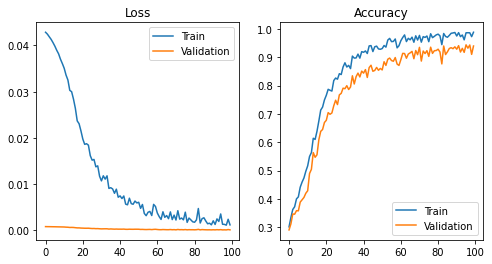

In [49]:
train_and_evaluate(gru, gru_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## CNN+LSTM

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.41283
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.35485
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.37245
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.46991
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.41459
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.38192
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.42502
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.39545
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.39187
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.38619
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.37064
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.41690
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.36859
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.37242
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.42283
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.20756
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.16381
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.32989
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.09392
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.22209
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.20200
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.19966
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.32194
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.19398
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.09717
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.38059
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.24769
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.11981
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.24819
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.27988
	Train loss: 0.03481, Accuracy: 3408/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.06268
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.22575
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.11452
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.06434
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.22155
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.02360
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 1.00690
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.17587
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.25751
	Train loss: 0.03144, Accuracy: 3756/6768 (55.00%)
	Validation loss: 0.00062, Accuracy: 917/1692 (54.00%)
	Test loss: 0.00065, Accuracy: 831/1772 (46.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.96807
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 1.17554
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 0.91094
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.13466
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 1.02785
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.89603
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.11378
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.08181
	Train loss: 0.02824, Accuracy: 4273/6768 (63.00%)
	Validation loss: 0.00057, Accuracy: 1010/1692 (59.00%)
	Test loss: 0.00064, Accuracy: 870/1772 (49.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.89176
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.23808
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 1.02870
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.18245
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 0.97282
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.95068
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.01556
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 1.06621
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 1.07967
Trainin

	Validation loss: 0.00049, Accuracy: 1120/1692 (66.00%)
	Test loss: 0.00061, Accuracy: 906/1772 (51.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.88856
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.18331
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 0.88486
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 1.10009
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 1.08969
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.84749
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 0.94915
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 1.20870
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 0.93605
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 1.08360
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.94573
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 1.01934
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 1.07411
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 1

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 1.11193
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.79246
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.83169
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 0.78075
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 1.01439
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 1.14409
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.81782
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 1.17323
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.90736
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 1.08501
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.98581
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.93835
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.98190
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.83229
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.88844
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.89910
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.79607
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 0.87957
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.94699
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 0.99874
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 1.04190
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 1.00613
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 1.03053
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 0.80899
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 1.00050
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.72369
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.89034
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 0.87853
	Train loss: 0.01879, Accuracy: 5246/6768 (77.00%)
	Validation loss: 0.00041, Accuracy: 1222/1692 (72.00%)
	Test loss: 0.00061, Accuracy: 953/1772 (53.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 0.85682
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 0.92138
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.78388
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 0.83954
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 0.92574
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.86607
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 0.76656
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.76616
	Train loss: 0.01749, Accuracy: 5498/6768 (81.00%)
	Validation loss: 0.00039, Accuracy: 1269/1692 (75.00%)
	Test loss: 0.00059, Accuracy: 983/1772 (55.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.75824
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 1.15659
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.88942
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.99996
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.89112
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.68210
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.90677
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 1.00228
	Train loss: 0.01511, Accuracy: 5675/6768 (83.00%)
	Validation loss: 0.00035, Accuracy: 1314/1692 (77.00%)
	Test loss: 0.00060, Accuracy: 981/1772 (55.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.59082
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 0.96585
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.67807
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.97777
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.72606
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.83993
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.68100
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 0.82647
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 1.07184
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.85644
Trainin

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.66449
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 1.17755
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.76389
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.64560
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.73866
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.59398
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.97751
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.80857
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.81468
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.79672
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.81200
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.80963
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.92248
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.71200
Training Progress: 	Epoch 48 [4480/6768 (66.04%)]		Loss: 0.84149
Training Progress: 	Epoch 48 [4800

Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.66140
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.65965
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.76003
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.83429
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 0.54696
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.79027
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.56621
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.68690
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.72862
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.74667
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.60925
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.76150
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.83050
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 1.03057
Training Progress: 	Epoch 53 [6080/6768 (89.62%)]		Loss: 0.67502
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.78298
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 1.10598
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.79089
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.98262
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.93148
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.83130
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.74794
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.76799
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.58741
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.46465
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.63119
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.55831
	Train loss: 0.00949, Accuracy: 6272/6768 (92.00%)
	Validation loss: 0.00026, Accuracy: 1453/1692 (85.00%)
	Test loss: 0.00062, Accuracy: 987/1772 (55.00%)

Training Progress: 	Epoch 59 [0/6768 (0.00%)]		Loss: 0.62769
Tr

Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.75352
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.84350
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.98146
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.75886
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.57937
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.63544
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.79171
	Train loss: 0.01056, Accuracy: 6199/6768 (91.00%)
	Validation loss: 0.00028, Accuracy: 1429/1692 (84.00%)
	Test loss: 0.00061, Accuracy: 991/1772 (55.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.58702
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.68986
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.76716
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.67522
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.59012
Training Progress: 	Epoch 64 [1600/6768 (23.58%)]		Loss: 0.53328
Trainin

Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.77811
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.73860
	Train loss: 0.00796, Accuracy: 6414/6768 (94.00%)
	Validation loss: 0.00022, Accuracy: 1489/1692 (88.00%)
	Test loss: 0.00061, Accuracy: 1046/1772 (59.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.64146
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.68978
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.52477
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.81845
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.75452
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.42254
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.53657
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.81173
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.57744
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.49713
Training Progress: 	Epoch 69 [3200/6768 (47.17%)]		Loss: 0.56900
Traini

Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.73271
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.58862
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.80828
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.77820
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.33509
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.46745
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.85668
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.63710
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.43975
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.58377
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.49360
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.79760
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.56786
Training Progress: 	Epoch 74 [4480/6768 (66.04%)]		Loss: 0.51599
Training Progress: 	Epoch 74 [4800/6768 (70.75%)]		Loss: 0.59246
Training Progress: 	Epoch 74 [

Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.42002
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.49648
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.52092
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.43626
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.43631
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.81621
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.77795
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.64929
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.51296
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.60438
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.52674
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.47327
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.80542
Training Progress: 	Epoch 79 [6080/6768 (89.62%)]		Loss: 0.53891
Training Progress: 	Epoch 79 [6400/6768 (94.34%)]		Loss: 0.75760
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.63053
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.54311
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.75000
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.75882
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.44546
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.75132
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.49625
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.65541
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.54573
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.55641
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.58734
	Train loss: 0.00445, Accuracy: 6617/6768 (97.00%)
	Validation loss: 0.00015, Accuracy: 1576/1692 (93.00%)
	Test loss: 0.00061, Accuracy: 1054/1772 (59.00%)

Training Progress: 	Epoch 85 [0/6768 (0.00%)]		Loss: 0.35489
Training Progress: 	Epoch 85 [320/6768 (4.72%)]		Loss: 0.86987
Tra

Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.85837
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.62277
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.55209
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.67197
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.47776
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.47075
	Train loss: 0.00407, Accuracy: 6618/6768 (97.00%)
	Validation loss: 0.00014, Accuracy: 1575/1692 (93.00%)
	Test loss: 0.00062, Accuracy: 1082/1772 (61.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.29155
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.64062
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.45277
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.78853
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.50730
Training Progress: 	Epoch 90 [1600/6768 (23.58%)]		Loss: 0.31652
Training Progress: 	Epoch 90 [1920/6768 (28.30%)]		Loss: 0.42769
Traini

Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.51003
	Train loss: 0.00346, Accuracy: 6633/6768 (98.00%)
	Validation loss: 0.00013, Accuracy: 1576/1692 (93.00%)
	Test loss: 0.00062, Accuracy: 1072/1772 (60.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.52505
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.63679
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.47891
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.69680
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.65134
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.56890
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.50677
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.54316
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.74397
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.42885
Training Progress: 	Epoch 95 [3200/6768 (47.17%)]		Loss: 0.36792
Training Progress: 	Epoch 95 [3520/6768 (51.89%)]		Loss: 0.62797
Traini

Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.23440
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.65573
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.52693
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.39174
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.55911
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.50449
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.61130
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.41643
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.28543
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.36753
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.73415
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.58376
Training Progress: 	Epoch 100 [4480/6768 (66.04%)]		Loss: 0.72532
Training Progress: 	Epoch 100 [4800/6768 (70.75%)]		Loss: 0.47836
Training Progress: 	Epoch 100 [5120/6768 (75.47%)]		Loss: 0.47424
Training Prog

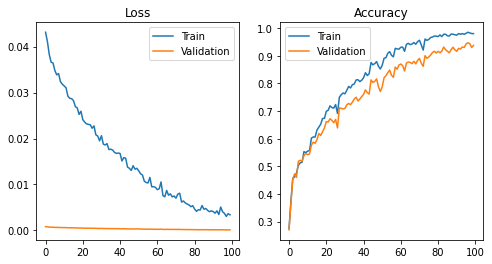

In [50]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## CNN+GRU

Training Progress: 	Epoch 1 [0/6768 (0.00%)]		Loss: 1.40381
Training Progress: 	Epoch 1 [320/6768 (4.72%)]		Loss: 1.56074
Training Progress: 	Epoch 1 [640/6768 (9.43%)]		Loss: 1.41990
Training Progress: 	Epoch 1 [960/6768 (14.15%)]		Loss: 1.50231
Training Progress: 	Epoch 1 [1280/6768 (18.87%)]		Loss: 1.46568
Training Progress: 	Epoch 1 [1600/6768 (23.58%)]		Loss: 1.51253
Training Progress: 	Epoch 1 [1920/6768 (28.30%)]		Loss: 1.38714
Training Progress: 	Epoch 1 [2240/6768 (33.02%)]		Loss: 1.38503
Training Progress: 	Epoch 1 [2560/6768 (37.74%)]		Loss: 1.39417
Training Progress: 	Epoch 1 [2880/6768 (42.45%)]		Loss: 1.43328
Training Progress: 	Epoch 1 [3200/6768 (47.17%)]		Loss: 1.50875
Training Progress: 	Epoch 1 [3520/6768 (51.89%)]		Loss: 1.38872
Training Progress: 	Epoch 1 [3840/6768 (56.60%)]		Loss: 1.46835
Training Progress: 	Epoch 1 [4160/6768 (61.32%)]		Loss: 1.38387
Training Progress: 	Epoch 1 [4480/6768 (66.04%)]		Loss: 1.44480
Training Progress: 	Epoch 1 [4800/6768 (70.75%)]	

Training Progress: 	Epoch 6 [2240/6768 (33.02%)]		Loss: 1.31625
Training Progress: 	Epoch 6 [2560/6768 (37.74%)]		Loss: 1.29869
Training Progress: 	Epoch 6 [2880/6768 (42.45%)]		Loss: 1.26399
Training Progress: 	Epoch 6 [3200/6768 (47.17%)]		Loss: 1.17159
Training Progress: 	Epoch 6 [3520/6768 (51.89%)]		Loss: 1.28525
Training Progress: 	Epoch 6 [3840/6768 (56.60%)]		Loss: 1.08833
Training Progress: 	Epoch 6 [4160/6768 (61.32%)]		Loss: 1.27012
Training Progress: 	Epoch 6 [4480/6768 (66.04%)]		Loss: 1.40289
Training Progress: 	Epoch 6 [4800/6768 (70.75%)]		Loss: 1.14476
Training Progress: 	Epoch 6 [5120/6768 (75.47%)]		Loss: 1.20884
Training Progress: 	Epoch 6 [5440/6768 (80.19%)]		Loss: 1.29402
Training Progress: 	Epoch 6 [5760/6768 (84.91%)]		Loss: 1.20786
Training Progress: 	Epoch 6 [6080/6768 (89.62%)]		Loss: 1.06586
Training Progress: 	Epoch 6 [6400/6768 (94.34%)]		Loss: 1.23081
Training Progress: 	Epoch 6 [6720/6768 (99.06%)]		Loss: 1.31777
	Train loss: 0.03492, Accuracy: 3353/676

Training Progress: 	Epoch 11 [4160/6768 (61.32%)]		Loss: 1.27217
Training Progress: 	Epoch 11 [4480/6768 (66.04%)]		Loss: 1.28484
Training Progress: 	Epoch 11 [4800/6768 (70.75%)]		Loss: 1.05434
Training Progress: 	Epoch 11 [5120/6768 (75.47%)]		Loss: 1.18085
Training Progress: 	Epoch 11 [5440/6768 (80.19%)]		Loss: 1.10155
Training Progress: 	Epoch 11 [5760/6768 (84.91%)]		Loss: 1.01003
Training Progress: 	Epoch 11 [6080/6768 (89.62%)]		Loss: 0.94580
Training Progress: 	Epoch 11 [6400/6768 (94.34%)]		Loss: 1.13560
Training Progress: 	Epoch 11 [6720/6768 (99.06%)]		Loss: 1.32002
	Train loss: 0.03121, Accuracy: 3889/6768 (57.00%)
	Validation loss: 0.00061, Accuracy: 978/1692 (57.00%)
	Test loss: 0.00065, Accuracy: 848/1772 (47.00%)

Training Progress: 	Epoch 12 [0/6768 (0.00%)]		Loss: 0.86309
Training Progress: 	Epoch 12 [320/6768 (4.72%)]		Loss: 0.98823
Training Progress: 	Epoch 12 [640/6768 (9.43%)]		Loss: 1.13335
Training Progress: 	Epoch 12 [960/6768 (14.15%)]		Loss: 1.01712
Training

Training Progress: 	Epoch 16 [5760/6768 (84.91%)]		Loss: 0.90573
Training Progress: 	Epoch 16 [6080/6768 (89.62%)]		Loss: 0.92661
Training Progress: 	Epoch 16 [6400/6768 (94.34%)]		Loss: 1.15894
Training Progress: 	Epoch 16 [6720/6768 (99.06%)]		Loss: 1.21802
	Train loss: 0.02782, Accuracy: 4238/6768 (62.00%)
	Validation loss: 0.00056, Accuracy: 1024/1692 (60.00%)
	Test loss: 0.00064, Accuracy: 884/1772 (49.00%)

Training Progress: 	Epoch 17 [0/6768 (0.00%)]		Loss: 0.96745
Training Progress: 	Epoch 17 [320/6768 (4.72%)]		Loss: 1.12478
Training Progress: 	Epoch 17 [640/6768 (9.43%)]		Loss: 0.98963
Training Progress: 	Epoch 17 [960/6768 (14.15%)]		Loss: 1.17505
Training Progress: 	Epoch 17 [1280/6768 (18.87%)]		Loss: 1.04683
Training Progress: 	Epoch 17 [1600/6768 (23.58%)]		Loss: 0.88390
Training Progress: 	Epoch 17 [1920/6768 (28.30%)]		Loss: 1.00185
Training Progress: 	Epoch 17 [2240/6768 (33.02%)]		Loss: 1.08823
Training Progress: 	Epoch 17 [2560/6768 (37.74%)]		Loss: 1.12705
Trainin

	Validation loss: 0.00051, Accuracy: 1109/1692 (65.00%)
	Test loss: 0.00062, Accuracy: 939/1772 (52.00%)

Training Progress: 	Epoch 22 [0/6768 (0.00%)]		Loss: 0.71147
Training Progress: 	Epoch 22 [320/6768 (4.72%)]		Loss: 1.10802
Training Progress: 	Epoch 22 [640/6768 (9.43%)]		Loss: 0.88411
Training Progress: 	Epoch 22 [960/6768 (14.15%)]		Loss: 0.97061
Training Progress: 	Epoch 22 [1280/6768 (18.87%)]		Loss: 1.03774
Training Progress: 	Epoch 22 [1600/6768 (23.58%)]		Loss: 0.95147
Training Progress: 	Epoch 22 [1920/6768 (28.30%)]		Loss: 1.04899
Training Progress: 	Epoch 22 [2240/6768 (33.02%)]		Loss: 1.12529
Training Progress: 	Epoch 22 [2560/6768 (37.74%)]		Loss: 1.19236
Training Progress: 	Epoch 22 [2880/6768 (42.45%)]		Loss: 0.86298
Training Progress: 	Epoch 22 [3200/6768 (47.17%)]		Loss: 0.89848
Training Progress: 	Epoch 22 [3520/6768 (51.89%)]		Loss: 1.00380
Training Progress: 	Epoch 22 [3840/6768 (56.60%)]		Loss: 1.03304
Training Progress: 	Epoch 22 [4160/6768 (61.32%)]		Loss: 0

Training Progress: 	Epoch 27 [1280/6768 (18.87%)]		Loss: 1.06560
Training Progress: 	Epoch 27 [1600/6768 (23.58%)]		Loss: 0.81453
Training Progress: 	Epoch 27 [1920/6768 (28.30%)]		Loss: 0.83981
Training Progress: 	Epoch 27 [2240/6768 (33.02%)]		Loss: 1.08588
Training Progress: 	Epoch 27 [2560/6768 (37.74%)]		Loss: 0.83557
Training Progress: 	Epoch 27 [2880/6768 (42.45%)]		Loss: 1.13794
Training Progress: 	Epoch 27 [3200/6768 (47.17%)]		Loss: 0.93502
Training Progress: 	Epoch 27 [3520/6768 (51.89%)]		Loss: 0.90496
Training Progress: 	Epoch 27 [3840/6768 (56.60%)]		Loss: 0.69640
Training Progress: 	Epoch 27 [4160/6768 (61.32%)]		Loss: 0.76401
Training Progress: 	Epoch 27 [4480/6768 (66.04%)]		Loss: 0.98373
Training Progress: 	Epoch 27 [4800/6768 (70.75%)]		Loss: 0.89933
Training Progress: 	Epoch 27 [5120/6768 (75.47%)]		Loss: 0.90111
Training Progress: 	Epoch 27 [5440/6768 (80.19%)]		Loss: 0.95941
Training Progress: 	Epoch 27 [5760/6768 (84.91%)]		Loss: 0.76397
Training Progress: 	Epoch

Training Progress: 	Epoch 32 [2880/6768 (42.45%)]		Loss: 0.77901
Training Progress: 	Epoch 32 [3200/6768 (47.17%)]		Loss: 0.70830
Training Progress: 	Epoch 32 [3520/6768 (51.89%)]		Loss: 1.01335
Training Progress: 	Epoch 32 [3840/6768 (56.60%)]		Loss: 0.63041
Training Progress: 	Epoch 32 [4160/6768 (61.32%)]		Loss: 1.00838
Training Progress: 	Epoch 32 [4480/6768 (66.04%)]		Loss: 0.93742
Training Progress: 	Epoch 32 [4800/6768 (70.75%)]		Loss: 0.95734
Training Progress: 	Epoch 32 [5120/6768 (75.47%)]		Loss: 0.90533
Training Progress: 	Epoch 32 [5440/6768 (80.19%)]		Loss: 1.04489
Training Progress: 	Epoch 32 [5760/6768 (84.91%)]		Loss: 0.63519
Training Progress: 	Epoch 32 [6080/6768 (89.62%)]		Loss: 0.57479
Training Progress: 	Epoch 32 [6400/6768 (94.34%)]		Loss: 0.90540
Training Progress: 	Epoch 32 [6720/6768 (99.06%)]		Loss: 1.02692
	Train loss: 0.01896, Accuracy: 5396/6768 (79.00%)
	Validation loss: 0.00042, Accuracy: 1256/1692 (74.00%)
	Test loss: 0.00063, Accuracy: 905/1772 (51.00%)

Training Progress: 	Epoch 37 [4480/6768 (66.04%)]		Loss: 1.13569
Training Progress: 	Epoch 37 [4800/6768 (70.75%)]		Loss: 1.02004
Training Progress: 	Epoch 37 [5120/6768 (75.47%)]		Loss: 0.80154
Training Progress: 	Epoch 37 [5440/6768 (80.19%)]		Loss: 1.09079
Training Progress: 	Epoch 37 [5760/6768 (84.91%)]		Loss: 1.10605
Training Progress: 	Epoch 37 [6080/6768 (89.62%)]		Loss: 0.70585
Training Progress: 	Epoch 37 [6400/6768 (94.34%)]		Loss: 1.02178
Training Progress: 	Epoch 37 [6720/6768 (99.06%)]		Loss: 0.90634
	Train loss: 0.01565, Accuracy: 5707/6768 (84.00%)
	Validation loss: 0.00036, Accuracy: 1334/1692 (78.00%)
	Test loss: 0.00063, Accuracy: 946/1772 (53.00%)

Training Progress: 	Epoch 38 [0/6768 (0.00%)]		Loss: 0.65656
Training Progress: 	Epoch 38 [320/6768 (4.72%)]		Loss: 0.86294
Training Progress: 	Epoch 38 [640/6768 (9.43%)]		Loss: 0.55018
Training Progress: 	Epoch 38 [960/6768 (14.15%)]		Loss: 0.88426
Training Progress: 	Epoch 38 [1280/6768 (18.87%)]		Loss: 0.62320
Trainin

Training Progress: 	Epoch 42 [6080/6768 (89.62%)]		Loss: 0.68053
Training Progress: 	Epoch 42 [6400/6768 (94.34%)]		Loss: 0.74887
Training Progress: 	Epoch 42 [6720/6768 (99.06%)]		Loss: 0.93519
	Train loss: 0.01439, Accuracy: 5936/6768 (87.00%)
	Validation loss: 0.00034, Accuracy: 1364/1692 (80.00%)
	Test loss: 0.00060, Accuracy: 1009/1772 (56.00%)

Training Progress: 	Epoch 43 [0/6768 (0.00%)]		Loss: 0.63179
Training Progress: 	Epoch 43 [320/6768 (4.72%)]		Loss: 1.01572
Training Progress: 	Epoch 43 [640/6768 (9.43%)]		Loss: 0.81654
Training Progress: 	Epoch 43 [960/6768 (14.15%)]		Loss: 0.92902
Training Progress: 	Epoch 43 [1280/6768 (18.87%)]		Loss: 0.88359
Training Progress: 	Epoch 43 [1600/6768 (23.58%)]		Loss: 0.70176
Training Progress: 	Epoch 43 [1920/6768 (28.30%)]		Loss: 0.69130
Training Progress: 	Epoch 43 [2240/6768 (33.02%)]		Loss: 1.04701
Training Progress: 	Epoch 43 [2560/6768 (37.74%)]		Loss: 0.66496
Training Progress: 	Epoch 43 [2880/6768 (42.45%)]		Loss: 0.61626
Traini

	Test loss: 0.00062, Accuracy: 1004/1772 (56.00%)

Training Progress: 	Epoch 48 [0/6768 (0.00%)]		Loss: 0.67121
Training Progress: 	Epoch 48 [320/6768 (4.72%)]		Loss: 0.81453
Training Progress: 	Epoch 48 [640/6768 (9.43%)]		Loss: 0.58598
Training Progress: 	Epoch 48 [960/6768 (14.15%)]		Loss: 0.76459
Training Progress: 	Epoch 48 [1280/6768 (18.87%)]		Loss: 0.92660
Training Progress: 	Epoch 48 [1600/6768 (23.58%)]		Loss: 0.62985
Training Progress: 	Epoch 48 [1920/6768 (28.30%)]		Loss: 0.81634
Training Progress: 	Epoch 48 [2240/6768 (33.02%)]		Loss: 0.86450
Training Progress: 	Epoch 48 [2560/6768 (37.74%)]		Loss: 0.70193
Training Progress: 	Epoch 48 [2880/6768 (42.45%)]		Loss: 0.95985
Training Progress: 	Epoch 48 [3200/6768 (47.17%)]		Loss: 0.72058
Training Progress: 	Epoch 48 [3520/6768 (51.89%)]		Loss: 0.80793
Training Progress: 	Epoch 48 [3840/6768 (56.60%)]		Loss: 0.70588
Training Progress: 	Epoch 48 [4160/6768 (61.32%)]		Loss: 0.82863
Training Progress: 	Epoch 48 [4480/6768 (66.04%)

Training Progress: 	Epoch 53 [1280/6768 (18.87%)]		Loss: 0.62171
Training Progress: 	Epoch 53 [1600/6768 (23.58%)]		Loss: 0.39821
Training Progress: 	Epoch 53 [1920/6768 (28.30%)]		Loss: 0.72747
Training Progress: 	Epoch 53 [2240/6768 (33.02%)]		Loss: 0.71340
Training Progress: 	Epoch 53 [2560/6768 (37.74%)]		Loss: 0.69837
Training Progress: 	Epoch 53 [2880/6768 (42.45%)]		Loss: 1.17767
Training Progress: 	Epoch 53 [3200/6768 (47.17%)]		Loss: 0.67326
Training Progress: 	Epoch 53 [3520/6768 (51.89%)]		Loss: 0.70095
Training Progress: 	Epoch 53 [3840/6768 (56.60%)]		Loss: 0.72648
Training Progress: 	Epoch 53 [4160/6768 (61.32%)]		Loss: 0.73818
Training Progress: 	Epoch 53 [4480/6768 (66.04%)]		Loss: 0.63736
Training Progress: 	Epoch 53 [4800/6768 (70.75%)]		Loss: 0.94533
Training Progress: 	Epoch 53 [5120/6768 (75.47%)]		Loss: 0.72520
Training Progress: 	Epoch 53 [5440/6768 (80.19%)]		Loss: 0.85435
Training Progress: 	Epoch 53 [5760/6768 (84.91%)]		Loss: 0.47571
Training Progress: 	Epoch

Training Progress: 	Epoch 58 [2880/6768 (42.45%)]		Loss: 0.77019
Training Progress: 	Epoch 58 [3200/6768 (47.17%)]		Loss: 0.50633
Training Progress: 	Epoch 58 [3520/6768 (51.89%)]		Loss: 0.70312
Training Progress: 	Epoch 58 [3840/6768 (56.60%)]		Loss: 0.74930
Training Progress: 	Epoch 58 [4160/6768 (61.32%)]		Loss: 0.76765
Training Progress: 	Epoch 58 [4480/6768 (66.04%)]		Loss: 0.64978
Training Progress: 	Epoch 58 [4800/6768 (70.75%)]		Loss: 0.68393
Training Progress: 	Epoch 58 [5120/6768 (75.47%)]		Loss: 0.44204
Training Progress: 	Epoch 58 [5440/6768 (80.19%)]		Loss: 0.68484
Training Progress: 	Epoch 58 [5760/6768 (84.91%)]		Loss: 0.53400
Training Progress: 	Epoch 58 [6080/6768 (89.62%)]		Loss: 0.60551
Training Progress: 	Epoch 58 [6400/6768 (94.34%)]		Loss: 0.79889
Training Progress: 	Epoch 58 [6720/6768 (99.06%)]		Loss: 0.61824
	Train loss: 0.00761, Accuracy: 6379/6768 (94.00%)
	Validation loss: 0.00021, Accuracy: 1500/1692 (88.00%)
	Test loss: 0.00060, Accuracy: 1053/1772 (59.00%

Training Progress: 	Epoch 63 [4480/6768 (66.04%)]		Loss: 0.73253
Training Progress: 	Epoch 63 [4800/6768 (70.75%)]		Loss: 0.52984
Training Progress: 	Epoch 63 [5120/6768 (75.47%)]		Loss: 0.84695
Training Progress: 	Epoch 63 [5440/6768 (80.19%)]		Loss: 0.70142
Training Progress: 	Epoch 63 [5760/6768 (84.91%)]		Loss: 0.48786
Training Progress: 	Epoch 63 [6080/6768 (89.62%)]		Loss: 0.37498
Training Progress: 	Epoch 63 [6400/6768 (94.34%)]		Loss: 0.73759
Training Progress: 	Epoch 63 [6720/6768 (99.06%)]		Loss: 0.60737
	Train loss: 0.00693, Accuracy: 6463/6768 (95.00%)
	Validation loss: 0.00020, Accuracy: 1515/1692 (89.00%)
	Test loss: 0.00060, Accuracy: 1061/1772 (59.00%)

Training Progress: 	Epoch 64 [0/6768 (0.00%)]		Loss: 0.51067
Training Progress: 	Epoch 64 [320/6768 (4.72%)]		Loss: 0.98130
Training Progress: 	Epoch 64 [640/6768 (9.43%)]		Loss: 0.59966
Training Progress: 	Epoch 64 [960/6768 (14.15%)]		Loss: 0.52030
Training Progress: 	Epoch 64 [1280/6768 (18.87%)]		Loss: 0.57610
Traini

Training Progress: 	Epoch 68 [6080/6768 (89.62%)]		Loss: 0.38616
Training Progress: 	Epoch 68 [6400/6768 (94.34%)]		Loss: 0.54430
Training Progress: 	Epoch 68 [6720/6768 (99.06%)]		Loss: 0.53608
	Train loss: 0.00596, Accuracy: 6530/6768 (96.00%)
	Validation loss: 0.00018, Accuracy: 1551/1692 (91.00%)
	Test loss: 0.00059, Accuracy: 1073/1772 (60.00%)

Training Progress: 	Epoch 69 [0/6768 (0.00%)]		Loss: 0.60877
Training Progress: 	Epoch 69 [320/6768 (4.72%)]		Loss: 0.94660
Training Progress: 	Epoch 69 [640/6768 (9.43%)]		Loss: 0.39460
Training Progress: 	Epoch 69 [960/6768 (14.15%)]		Loss: 0.71986
Training Progress: 	Epoch 69 [1280/6768 (18.87%)]		Loss: 0.77257
Training Progress: 	Epoch 69 [1600/6768 (23.58%)]		Loss: 0.51055
Training Progress: 	Epoch 69 [1920/6768 (28.30%)]		Loss: 0.66863
Training Progress: 	Epoch 69 [2240/6768 (33.02%)]		Loss: 0.87635
Training Progress: 	Epoch 69 [2560/6768 (37.74%)]		Loss: 0.53753
Training Progress: 	Epoch 69 [2880/6768 (42.45%)]		Loss: 0.52367
Traini

	Test loss: 0.00059, Accuracy: 1083/1772 (61.00%)

Training Progress: 	Epoch 74 [0/6768 (0.00%)]		Loss: 0.46181
Training Progress: 	Epoch 74 [320/6768 (4.72%)]		Loss: 0.73164
Training Progress: 	Epoch 74 [640/6768 (9.43%)]		Loss: 0.46240
Training Progress: 	Epoch 74 [960/6768 (14.15%)]		Loss: 0.67816
Training Progress: 	Epoch 74 [1280/6768 (18.87%)]		Loss: 0.59355
Training Progress: 	Epoch 74 [1600/6768 (23.58%)]		Loss: 0.37089
Training Progress: 	Epoch 74 [1920/6768 (28.30%)]		Loss: 0.62654
Training Progress: 	Epoch 74 [2240/6768 (33.02%)]		Loss: 0.50837
Training Progress: 	Epoch 74 [2560/6768 (37.74%)]		Loss: 0.69123
Training Progress: 	Epoch 74 [2880/6768 (42.45%)]		Loss: 0.47999
Training Progress: 	Epoch 74 [3200/6768 (47.17%)]		Loss: 0.47971
Training Progress: 	Epoch 74 [3520/6768 (51.89%)]		Loss: 0.55185
Training Progress: 	Epoch 74 [3840/6768 (56.60%)]		Loss: 0.57376
Training Progress: 	Epoch 74 [4160/6768 (61.32%)]		Loss: 0.53283
Training Progress: 	Epoch 74 [4480/6768 (66.04%)

Training Progress: 	Epoch 79 [1280/6768 (18.87%)]		Loss: 0.69026
Training Progress: 	Epoch 79 [1600/6768 (23.58%)]		Loss: 0.40283
Training Progress: 	Epoch 79 [1920/6768 (28.30%)]		Loss: 0.64746
Training Progress: 	Epoch 79 [2240/6768 (33.02%)]		Loss: 0.87857
Training Progress: 	Epoch 79 [2560/6768 (37.74%)]		Loss: 0.46098
Training Progress: 	Epoch 79 [2880/6768 (42.45%)]		Loss: 0.32234
Training Progress: 	Epoch 79 [3200/6768 (47.17%)]		Loss: 0.68934
Training Progress: 	Epoch 79 [3520/6768 (51.89%)]		Loss: 0.40987
Training Progress: 	Epoch 79 [3840/6768 (56.60%)]		Loss: 0.55330
Training Progress: 	Epoch 79 [4160/6768 (61.32%)]		Loss: 0.43039
Training Progress: 	Epoch 79 [4480/6768 (66.04%)]		Loss: 0.50487
Training Progress: 	Epoch 79 [4800/6768 (70.75%)]		Loss: 0.42877
Training Progress: 	Epoch 79 [5120/6768 (75.47%)]		Loss: 0.66293
Training Progress: 	Epoch 79 [5440/6768 (80.19%)]		Loss: 0.48737
Training Progress: 	Epoch 79 [5760/6768 (84.91%)]		Loss: 0.56094
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [2880/6768 (42.45%)]		Loss: 0.45132
Training Progress: 	Epoch 84 [3200/6768 (47.17%)]		Loss: 0.51531
Training Progress: 	Epoch 84 [3520/6768 (51.89%)]		Loss: 0.36921
Training Progress: 	Epoch 84 [3840/6768 (56.60%)]		Loss: 0.47951
Training Progress: 	Epoch 84 [4160/6768 (61.32%)]		Loss: 0.49902
Training Progress: 	Epoch 84 [4480/6768 (66.04%)]		Loss: 0.61684
Training Progress: 	Epoch 84 [4800/6768 (70.75%)]		Loss: 0.51367
Training Progress: 	Epoch 84 [5120/6768 (75.47%)]		Loss: 0.61821
Training Progress: 	Epoch 84 [5440/6768 (80.19%)]		Loss: 0.57565
Training Progress: 	Epoch 84 [5760/6768 (84.91%)]		Loss: 0.63693
Training Progress: 	Epoch 84 [6080/6768 (89.62%)]		Loss: 0.39461
Training Progress: 	Epoch 84 [6400/6768 (94.34%)]		Loss: 0.60182
Training Progress: 	Epoch 84 [6720/6768 (99.06%)]		Loss: 0.56004
	Train loss: 0.00363, Accuracy: 6635/6768 (98.00%)
	Validation loss: 0.00013, Accuracy: 1601/1692 (94.00%)
	Test loss: 0.00060, Accuracy: 1093/1772 (61.00%

Training Progress: 	Epoch 89 [4480/6768 (66.04%)]		Loss: 0.55449
Training Progress: 	Epoch 89 [4800/6768 (70.75%)]		Loss: 0.61474
Training Progress: 	Epoch 89 [5120/6768 (75.47%)]		Loss: 0.39223
Training Progress: 	Epoch 89 [5440/6768 (80.19%)]		Loss: 0.44002
Training Progress: 	Epoch 89 [5760/6768 (84.91%)]		Loss: 0.58517
Training Progress: 	Epoch 89 [6080/6768 (89.62%)]		Loss: 0.49531
Training Progress: 	Epoch 89 [6400/6768 (94.34%)]		Loss: 0.50247
Training Progress: 	Epoch 89 [6720/6768 (99.06%)]		Loss: 0.73391
	Train loss: 0.00321, Accuracy: 6624/6768 (97.00%)
	Validation loss: 0.00011, Accuracy: 1595/1692 (94.00%)
	Test loss: 0.00062, Accuracy: 1099/1772 (62.00%)

Training Progress: 	Epoch 90 [0/6768 (0.00%)]		Loss: 0.35739
Training Progress: 	Epoch 90 [320/6768 (4.72%)]		Loss: 0.48877
Training Progress: 	Epoch 90 [640/6768 (9.43%)]		Loss: 0.34562
Training Progress: 	Epoch 90 [960/6768 (14.15%)]		Loss: 0.82512
Training Progress: 	Epoch 90 [1280/6768 (18.87%)]		Loss: 0.56321
Traini

Training Progress: 	Epoch 94 [6080/6768 (89.62%)]		Loss: 0.29494
Training Progress: 	Epoch 94 [6400/6768 (94.34%)]		Loss: 0.52735
Training Progress: 	Epoch 94 [6720/6768 (99.06%)]		Loss: 0.57930
	Train loss: 0.00340, Accuracy: 6602/6768 (97.00%)
	Validation loss: 0.00011, Accuracy: 1581/1692 (93.00%)
	Test loss: 0.00066, Accuracy: 1058/1772 (59.00%)

Training Progress: 	Epoch 95 [0/6768 (0.00%)]		Loss: 0.50214
Training Progress: 	Epoch 95 [320/6768 (4.72%)]		Loss: 0.72671
Training Progress: 	Epoch 95 [640/6768 (9.43%)]		Loss: 0.29510
Training Progress: 	Epoch 95 [960/6768 (14.15%)]		Loss: 0.90903
Training Progress: 	Epoch 95 [1280/6768 (18.87%)]		Loss: 0.29186
Training Progress: 	Epoch 95 [1600/6768 (23.58%)]		Loss: 0.26699
Training Progress: 	Epoch 95 [1920/6768 (28.30%)]		Loss: 0.46162
Training Progress: 	Epoch 95 [2240/6768 (33.02%)]		Loss: 0.65780
Training Progress: 	Epoch 95 [2560/6768 (37.74%)]		Loss: 0.60022
Training Progress: 	Epoch 95 [2880/6768 (42.45%)]		Loss: 0.58467
Traini

	Test loss: 0.00063, Accuracy: 1091/1772 (61.00%)

Training Progress: 	Epoch 100 [0/6768 (0.00%)]		Loss: 0.20872
Training Progress: 	Epoch 100 [320/6768 (4.72%)]		Loss: 0.49007
Training Progress: 	Epoch 100 [640/6768 (9.43%)]		Loss: 0.29785
Training Progress: 	Epoch 100 [960/6768 (14.15%)]		Loss: 0.55326
Training Progress: 	Epoch 100 [1280/6768 (18.87%)]		Loss: 0.41574
Training Progress: 	Epoch 100 [1600/6768 (23.58%)]		Loss: 0.57971
Training Progress: 	Epoch 100 [1920/6768 (28.30%)]		Loss: 0.40500
Training Progress: 	Epoch 100 [2240/6768 (33.02%)]		Loss: 0.52476
Training Progress: 	Epoch 100 [2560/6768 (37.74%)]		Loss: 0.47743
Training Progress: 	Epoch 100 [2880/6768 (42.45%)]		Loss: 0.27496
Training Progress: 	Epoch 100 [3200/6768 (47.17%)]		Loss: 0.68290
Training Progress: 	Epoch 100 [3520/6768 (51.89%)]		Loss: 0.46199
Training Progress: 	Epoch 100 [3840/6768 (56.60%)]		Loss: 0.53693
Training Progress: 	Epoch 100 [4160/6768 (61.32%)]		Loss: 0.51132
Training Progress: 	Epoch 100 [448

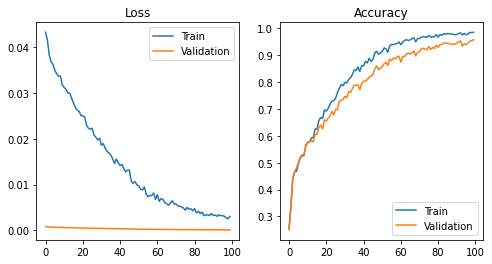

In [51]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders_acgan, num_epochs=EPOCHS)